## Problem 3
- [Given the images of 20000 persons](https://www.kaggle.com/datasets/jangedoo/utkface-new)
- Predict the age and gender

# Imports

In [4]:
import os
import pandas as pd
import numpy as np

In [5]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import *

# Import Dataset

#### Local

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!pip install kaggle kagglehub

!kaggle datasets download -d jangedoo/utkface-new -p A

import zipfile
zip_ref = zipfile.ZipFile('A/utkface-new.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

!rm -rf 'utkface-new.zip'

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors


'rm' is not recognized as an internal or external command,
operable program or batch file.


#### Colab

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!pip install kaggle kagglehub

!kaggle datasets download -d jangedoo/utkface-new

import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

!rm -rf 'utkface-new.zip'

# Prepare dataset for model training and testing

The images are named as age, gender, ethnicity

In [6]:
!ls

data_problem3			prob3.txt	test_data_problem3.csv
data_problem3.csv		problem3.ipynb	train_dat_problem3a.csv
Dummy_Models			README
model_problem3_untrained.keras	README.md


In [7]:
# folder_path = 'data_problem3' ## Local
folder_path = 'data_problem3' ## Colab

In [8]:
df = pd.DataFrame(columns=['file_name', 'age', 'gender'])

In [9]:
for file in os.listdir(folder_path):

    if not(file.endswith('.jpg')):
        continue

    parts = file.split('_')
    age = parts[0]
    gender = parts[1]
    df = pd.concat([df, pd.DataFrame({'file_name': [file], 'age': [age], 'gender': [gender]})], ignore_index=True)

In [10]:
df['age'] = df['age'].astype(int)
df['gender'] = df['gender'].astype(int)

In [11]:
df.head()

,file_name,age,gender
0,50_1_1_20170120220813715.jpg.chip.jpg,50,1
1,50_1_1_20170120222821475.jpg.chip.jpg,50,1
2,50_1_2_20170116173220910.jpg.chip.jpg,50,1
3,50_1_3_20170117143102562.jpg.chip.jpg,50,1
4,50_1_3_20170117151044708.jpg.chip.jpg,50,1


In [12]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [13]:
print(df.shape)
print(train_df.shape)
print(test_df.shape)

(23709, 3)
(20000, 3)
(3709, 3)


In [14]:
df.to_csv('data_problem3.csv')
train_df.to_csv('train_dat_problem3a.csv')
test_df.to_csv('test_data_problem3.csv')

# Generate Data for Training

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=folder_path,
    x_col='file_name',
    y_col=['age', 'gender'],
    target_size=(234, 234),
    batch_size=32,
    class_mode='multi_output'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_path,
    x_col='file_name',
    y_col=['age', 'gender'],
    target_size=(234, 234),
    batch_size=32,
    class_mode='multi_output'
)

Found 20000 validated image filenames.
Found 3709 validated image filenames.


# Define model architecture

In [16]:
conv_base = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (234,234,3)
)

conv_base.trainable = False

conv_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 234, 234,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 117, 117,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 117, 117,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 117, 117,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 119, 119,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 59, 59,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 59, 59,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 59, 59,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 59, 59,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 59, 59,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 59, 59,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 59, 59,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 59, 59,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 59, 59,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 59, 59,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 59, 59,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
conv_output_layer = conv_base.layers[-1].output

flatten = Flatten(name='flatten_layer')(conv_output_layer)

fc_l1 = Dense(units=512, activation='relu', name='fc_l1')(flatten)
fc_l2 = Dense(units=128, activation='relu', name='fc_l2')(fc_l1)
fc_l3 = Dense(units=32, activation='relu', name='fc_l3')(fc_l2)
output_age = Dense(units=1, activation='linear', name='output_layer_age')(fc_l3)
output_gender = Dense(units=1, activation='sigmoid', name='output_layer_gender')(fc_l3)

model = Model(inputs=conv_base.input, outputs=[output_age, output_gender])
model.name = 'resnet50_transfer_learning'
model.summary()

Model: "resnet50_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 234, 234,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 117, 117,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 117, 117,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 117, 117,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 119, 119,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 59, 59,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 59, 59,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 59, 59,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 59, 59,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 59, 59,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 59, 59,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 59, 59,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 59, 59,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 59, 59,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 59, 59,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 59, 59,    │      1,024 │ conv2_block1_3_c

 Total params: 90,766,946 (346.25 MB)

 Trainable params: 67,179,234 (256.27 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

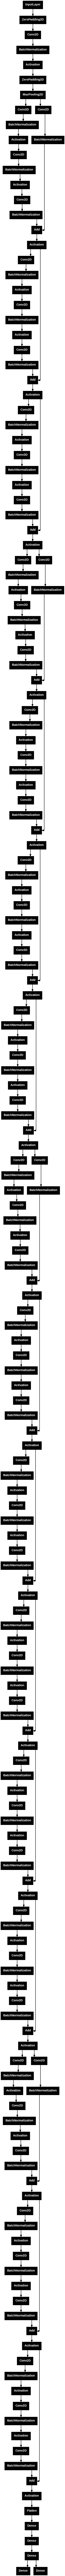

In [18]:
tensorflow.keras.utils.plot_model(model)

In [19]:
model.save('model_problem3_untrained.keras')

# Train model

In [29]:
model.compile(
    loss={'output_age': 'mae', 'output_gender': 'binary_crossentropy'},
    optimizer=RMSprop(learning_rate=1e-5),
    metrics={'output_age': 'mae', 'output_gender': 'accuracy'},
    loss_weights={'output_age':1, 'output_gender':99}
    )

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
).history

model.save('model_problem3_trained.keras')

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

# Test Results

In [ ]:
plt.plot(history['loss'], label='Training', color='red')
plt.plot(history['val_loss'], label='Validation', color='blue')
plt.legend()
plt.show()
plt.savefig('loss.png')